In [14]:
#Importamos todas las librerias correspondientes a nuestro trabajo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import tensorflow as tf

In [15]:
def cargarDataSets(train_file,test_file):
    train_file_map = scipy.io.loadmat(train_file)
    test_file_map = scipy.io.loadmat(test_file)
    train_data = train_file_map['X']
    train_labels = np.array(train_file_map['y'])
    train_labels = train_labels.reshape(len(train_labels))
    test_labels = test_file_map['y']
    test_labels = test_labels.reshape((len(test_labels)))
    mitad = int(len(test_labels)/2)
    valid_labels = test_labels[mitad:]
    test_labels = test_labels[:mitad]
    test_data = test_file_map['X']
    valid_data = test_data[:,:,:,mitad:]
    test_data = test_data [:,:,:,:mitad]
    train_data_set = ( train_data[:,:,0,:] + train_data[:,:,1,:]+ train_data[:,:,2,:] )/3
    test_data_set = ( test_data[:,:,0,:] + test_data[:,:,1,:] + test_data[:,:,2,:] )/3
    valid_data_set = ( valid_data[:,:,0,:] + valid_data[:,:,1,:] + valid_data[:,:,2,:] )/3
    return train_data_set,train_labels,test_data_set,test_labels,valid_data_set,valid_labels

In [16]:
image_size = 32
num_labels = 11
def reformatLabels(labels):
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]\n",
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return labels

In [39]:
image_size = 32
num_channels = 1
def reformatDataSet(dataSet):
    nuevoDataSet = dataSet.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    for i in range (len(nuevoDataSet)):
        nuevoDataSet[i,:,:,0] = nuevoDataSet[i,:,:,0].T
    return nuevoDataSet

In [40]:
def normalizarDataSet(dataSet):
    return (dataSet/128) - 0.5

In [47]:
def comprobarIntegridadEntrenamiento(train_data,train_labels):
    aleatorio = np.random.randint(0,len(train_labels))
    imagen = train_data[aleatorio,:,:,0]
    print("Prueba de integridad en el data set de Entrenamiento")
    plt.imshow(imagen , cmap = 'gray')
    print ("La clase de esta imagen es :",np.argmax(train_labels[aleatorio]))

In [48]:
def comprobarIntegridadTest(test_data,test_labels):
    aleatorio = np.random.randint(0,len(test_labels))
    imagen = test_data[aleatorio,:,:,0]
    print("Prueba de integridad en el data set de Test")
    plt.imshow(imagen , cmap = 'gray')
    print ("La clase de esta imagen es :",np.argmax(test_labels[aleatorio]))

In [49]:
def comprobarIntegridadValid(valid_data,valid_labels):
    aleatorio = np.random.randint(0,len(valid_labels))
    imagen = valid_data[aleatorio,:,:,0]
    print("Prueba de integridad en el data set de validación")
    plt.imshow(imagen , cmap = 'gray')
    print ("La clase de esta imagen es :",np.argmax(valid_labels[aleatorio]))

In [50]:
num_channels = 1
image_size = 32
train_file = 'train_32x32.mat'
test_file = 'test_32x32.mat'
train_data,train_labels,test_data,test_labels,valid_data,valid_labels = cargarDataSets(train_file,test_file)
train_data = reformatDataSet(normalizarDataSet(train_data.T))
train_labels = reformatLabels(train_labels)
test_data = reformatDataSet(normalizarDataSet(test_data.T))
test_labels = reformatLabels(test_labels)
valid_labels = reformatLabels(valid_labels)
valid_data = reformatDataSet(normalizarDataSet(valid_data.T))

Prueba de integridad en el data set de Entrenamiento
La clase de esta imagen es : 1


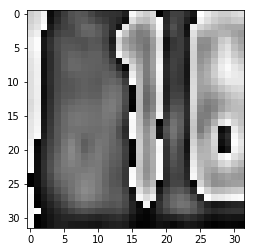

In [60]:
comprobarIntegridadEntrenamiento(train_data,train_labels)

Prueba de integridad en el data set de Test
La clase de esta imagen es : 1


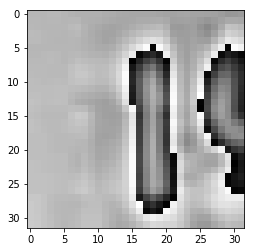

In [67]:
comprobarIntegridadTest(test_data,test_labels)

Prueba de integridad en el data set de validación
La clase de esta imagen es : 4


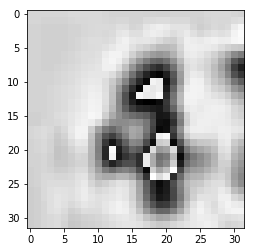

In [83]:
comprobarIntegridadValid(valid_data,valid_labels)

In [84]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

In [93]:
#Red neuronal convolucional
batch_size = 64
patch_size = 5
depth = 16
num_hidden = 64
num_channels = 1
keep_prob = 0.85
Beta = 0.0001
graph = tf.Graph()

with graph.as_default():

    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset =  tf.to_float( tf.constant(valid_data) )
    tf_test_dataset = tf.to_float( tf.constant(test_data) )
    
    # Variables.
    layer1_weights = tf.to_float( tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1)) )
    layer1_biases = tf.to_float( tf.Variable(tf.zeros([depth])) )
    layer2_weights = tf.to_float( tf.Variable(tf.truncated_normal(
    [patch_size, patch_size, depth, depth], stddev=0.1)) )
    layer2_biases = tf.to_float( tf.Variable(tf.constant(1.0, shape=[depth])) )
    layer3_weights = tf.to_float ( tf.Variable(tf.truncated_normal(
    [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1)) )
    layer3_biases = tf.to_float ( tf.Variable(tf.constant(1.0, shape=[num_hidden])) )
    layer4_weights = tf.to_float( tf.Variable(tf.truncated_normal(
    [num_hidden, num_labels], stddev=0.1)))
    layer4_biases = tf.to_float( tf.Variable(tf.constant(1.0, shape=[num_labels])) )

    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        conv = tf.nn.max_pool(value=conv , ksize=[1,2,2,1] , strides= [1,2,2,1] ,padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        hidden = tf.nn.dropout( hidden, keep_prob )
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        conv = tf.nn.max_pool(value=conv , ksize=[1,2,2,1] , strides= [1,2,2,1] ,padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = tf.nn.dropout( hidden, keep_prob )
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.\n",
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    loss = tf.reduce_mean( loss + Beta*(tf.nn.l2_loss(layer1_weights)+
                                         tf.nn.l2_loss(layer2_weights)+ tf.nn.l2_loss(layer3_weights)+
                                         tf.nn.l2_loss(layer4_weights)))

    # Optimizer
    optimizer = tf.train.AdagradOptimizer(0.08).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [95]:
num_steps = 5001
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_data[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.126918
Minibatch accuracy: 12.5%
Validation accuracy: 7.5%
Minibatch loss at step 100: 2.238122
Minibatch accuracy: 23.4%
Validation accuracy: 19.5%
Minibatch loss at step 200: 2.219296
Minibatch accuracy: 17.2%
Validation accuracy: 19.3%
Minibatch loss at step 300: 2.226187
Minibatch accuracy: 17.2%
Validation accuracy: 19.1%
Minibatch loss at step 400: 2.239778
Minibatch accuracy: 18.8%
Validation accuracy: 20.3%
Minibatch loss at step 500: 1.945467
Minibatch accuracy: 31.2%
Validation accuracy: 34.3%
Minibatch loss at step 600: 1.493962
Minibatch accuracy: 43.8%
Validation accuracy: 37.9%
Minibatch loss at step 700: 1.878583
Minibatch accuracy: 39.1%
Validation accuracy: 49.9%
Minibatch loss at step 800: 1.487318
Minibatch accuracy: 45.3%
Validation accuracy: 55.1%
Minibatch loss at step 900: 1.391232
Minibatch accuracy: 46.9%
Validation accuracy: 58.5%
Minibatch loss at step 1000: 1.163028
Minibatch accuracy: 65.6%
Validation accuracy: 59.5%
